In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '57-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.0003 to 7.86e-05


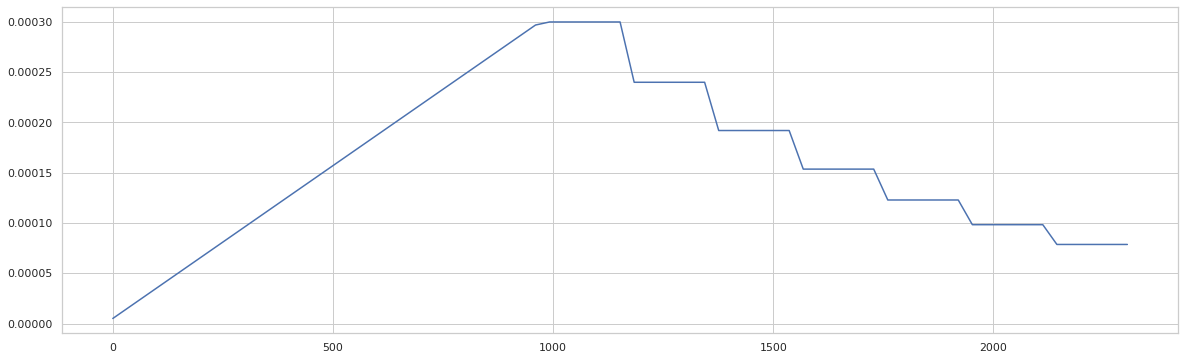

In [11]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [13]:
# Initial bias

pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [14]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [27]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
194/194 - 39s - loss: 1.6093 - auc: 0.6203 - val_loss: 0.1849 - val_auc: 0.7342
Epoch 2/12
194/194 - 26s - loss: 0.5554 - auc: 0.8338 - val_loss: 0.3403 - val_auc: 0.8612
Epoch 3/12
194/194 - 26s - loss: 0.4875 - auc: 0.8604 - val_loss: 0.3288 - val_auc: 0.8667
Epoch 4/12
194/194 - 24s - loss: 0.4705 - auc: 0.8742 - val_loss: 0.3099 - val_auc: 0.8610
Epoch 5/12
194/194 - 26s - loss: 0.4588 - auc: 0.8853 - val_loss: 0.3887 - val_auc: 0.8685
Epoch 6/12
194/194 - 25s - loss: 0.4379 - auc: 0.8969 - val_loss: 0.4442 - val_auc: 0.8799
Epoch 7/12
194/194 - 26s - loss: 0.4086 - auc: 0.9162 - val_loss: 0.3504 - val_auc: 0.8881
Epoch 8/12
194/194 - 24s - loss: 0.3729 - auc: 0.9317 - val_loss: 0.4204 - val_auc: 0.8844
Epoch 9/12
194/194 - 26s - loss: 0.3638 - auc: 0.9392 - val_loss: 0.3427 - val_auc: 0.8999
Epoch 10/12
194/194 - 24s - loss: 0.3432 - auc: 0.9484 - val_loss: 0.2999 - val_auc: 0.8915
Epoch 11/12
194/194 - 24s - loss: 0.3249 - auc: 0.9575 - val_loss: 0.3492 - val_auc: 0.89

INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 40s - loss: 1.5030 - auc: 0.6549 - val_loss: 0.1857 - val_auc: 0.7246
Epoch 2/12
210/210 - 29s - loss: 0.5336 - auc: 0.8437 - val_loss: 0.3036 - val_auc: 0.8830
Epoch 3/12
210/210 - 28s - loss: 0.4730 - auc: 0.8740 - val_loss: 0.2895 - val_auc: 0.8910
Epoch 4/12
210/210 - 28s - loss: 0.4572 - auc: 0.8817 - val_loss: 0.3670 - val_auc: 0.8930
Epoch 5/12
210/210 - 25s - loss: 0.4598 - auc: 0.8833 - val_loss: 0.3669 - val_auc: 0.8784
Epoch 6/12
210/210 - 25s - loss: 0.4294 - auc: 0.9002 - val_loss: 0.3602 - val_auc: 0.8719
Epoch 7/12
210/210 - 25s - loss: 0.3925 - auc: 0.9207 - val_loss: 0.3499 - val_auc: 0.8819
Epoch 8/12
210/210 - 27s - loss: 0.3775 - auc: 0.9300 - val_loss: 0.3379 - val_auc: 0.8940
Epoch 9/12
210/210 - 27s - loss: 0.3531 - auc: 0.9426 - val_loss: 0.3302 - val_auc: 0.8970
Epoch 10/12
210/210 - 25s - loss: 0.3393 - auc: 0.9502 - val_loss: 0.3962 - val_auc: 0.8946
Epoch 11/12
210/210 - 27s - loss: 0.3117 - auc: 0.9591 - val_loss: 0.2884 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 39s - loss: 1.4934 - auc: 0.6637 - val_loss: 0.1855 - val_auc: 0.7539
Epoch 2/12
210/210 - 27s - loss: 0.5264 - auc: 0.8428 - val_loss: 0.3132 - val_auc: 0.8658
Epoch 3/12
210/210 - 27s - loss: 0.4596 - auc: 0.8795 - val_loss: 0.3420 - val_auc: 0.8787
Epoch 4/12
210/210 - 26s - loss: 0.4612 - auc: 0.8825 - val_loss: 0.3983 - val_auc: 0.8819
Epoch 5/12
210/210 - 25s - loss: 0.4503 - auc: 0.8842 - val_loss: 0.4368 - val_auc: 0.8804
Epoch 6/12
210/210 - 27s - loss: 0.4318 - auc: 0.8996 - val_loss: 0.4917 - val_auc: 0.8904
Epoch 7/12
210/210 - 26s - loss: 0.3966 - auc: 0.9206 - val_loss: 0.4741 - val_auc: 0.9066
Epoch 8/12
210/210 - 25s - loss: 0.3763 - auc: 0.9317 - val_loss: 0.5068 - val_auc: 0.8901
Epoch 9/12
210/210 - 25s - loss: 0.3381 - auc: 0.9480 - val_loss: 0.3180 - val_auc: 0.9058
Epoch 10/12
210/210 - 25s - loss: 0.3258 - auc: 0.9562 - val_loss: 0.3232 - val_auc: 0.9043
Epoch 11/12
210/210 - 24s - loss: 0.3227 - auc: 0.9565 - val_loss: 0.2981 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 38s - loss: 1.4806 - auc: 0.6311 - val_loss: 0.1819 - val_auc: 0.7598
Epoch 2/12
210/210 - 27s - loss: 0.5212 - auc: 0.8467 - val_loss: 0.2825 - val_auc: 0.8717
Epoch 3/12
210/210 - 27s - loss: 0.4812 - auc: 0.8645 - val_loss: 0.2787 - val_auc: 0.8736
Epoch 4/12
210/210 - 27s - loss: 0.4637 - auc: 0.8797 - val_loss: 0.4003 - val_auc: 0.8787
Epoch 5/12
210/210 - 27s - loss: 0.4454 - auc: 0.8920 - val_loss: 0.3919 - val_auc: 0.8830
Epoch 6/12
210/210 - 29s - loss: 0.4280 - auc: 0.9025 - val_loss: 0.3726 - val_auc: 0.8861
Epoch 7/12
210/210 - 27s - loss: 0.4087 - auc: 0.9159 - val_loss: 0.3803 - val_auc: 0.9051
Epoch 8/12
210/210 - 27s - loss: 0.3637 - auc: 0.9363 - val_loss: 0.2922 - val_auc: 0.9073
Epoch 9/12
210/210 - 29s - loss: 0.3557 - auc: 0.9421 - val_loss: 0.2788 - val_auc: 0.9082
Epoch 10/12
210/210 - 25s - loss: 0.3339 - auc: 0.9519 - val_loss: 0.2965 - val_auc: 0.9040
Epoch 11/12
210/210 - 25s - loss: 0.3100 - auc: 0.9613 - val_loss: 0.2687 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.178.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 40s - loss: 1.5292 - auc: 0.6462 - val_loss: 0.1871 - val_auc: 0.7442
Epoch 2/12
210/210 - 27s - loss: 0.5227 - auc: 0.8391 - val_loss: 0.3541 - val_auc: 0.8734
Epoch 3/12
210/210 - 27s - loss: 0.4842 - auc: 0.8625 - val_loss: 0.3714 - val_auc: 0.8858
Epoch 4/12
210/210 - 27s - loss: 0.4583 - auc: 0.8826 - val_loss: 0.3719 - val_auc: 0.8972
Epoch 5/12
210/210 - 25s - loss: 0.4560 - auc: 0.8820 - val_loss: 0.4468 - val_auc: 0.8823
Epoch 6/12
210/210 - 27s - loss: 0.4240 - auc: 0.9049 - val_loss: 0.3008 - val_auc: 0.8977
Epoch 7/12
210/210 - 26s - loss: 0.4097 - auc: 0.9162 - val_loss: 0.3805 - val_auc: 0.8988
Epoch 8/12
210/210 - 27s - loss: 0.3773 - auc: 0.9301 - val_loss: 0.3093 - val_auc: 0.9028
Epoch 9/12
210/210 - 27s - loss: 0.3532 - auc: 0.9430 - val_loss: 0.3273 - val_auc: 0.9059
Epoch 10/12
210/210 - 25s - loss: 0.3286 - auc: 0.9544 - val_loss: 0.2568 - val_auc: 0.9024
Epoch 11/12
210/210 - 27s - loss: 0.3350 - auc: 0.9526 - val_loss: 0.3573 - val_auc: 0.90

## Model loss graph

Fold: 1


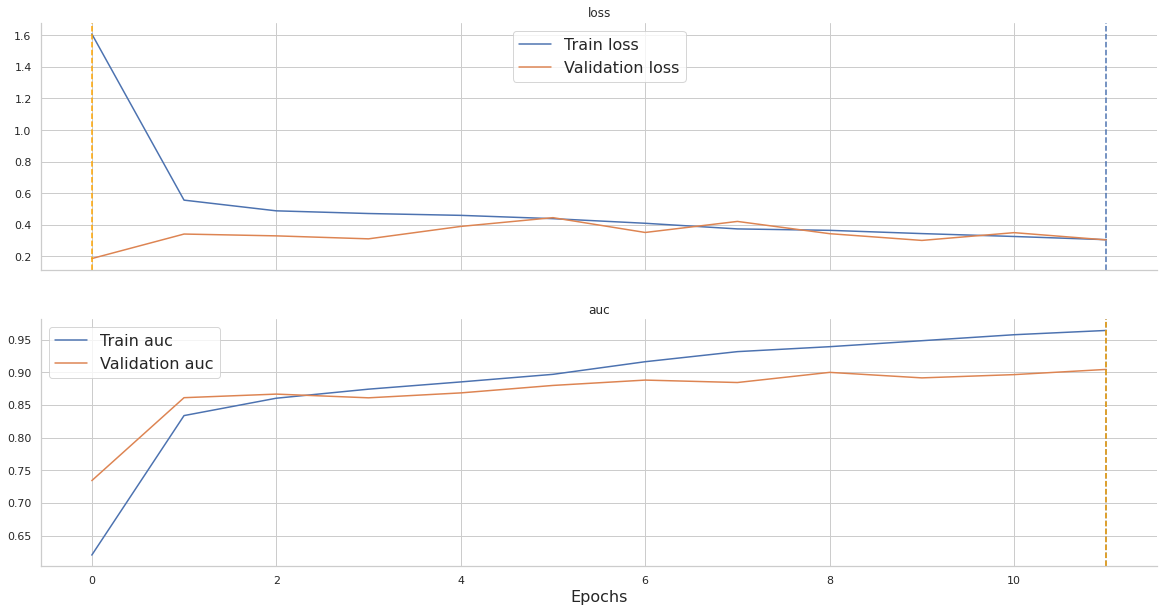

Fold: 2


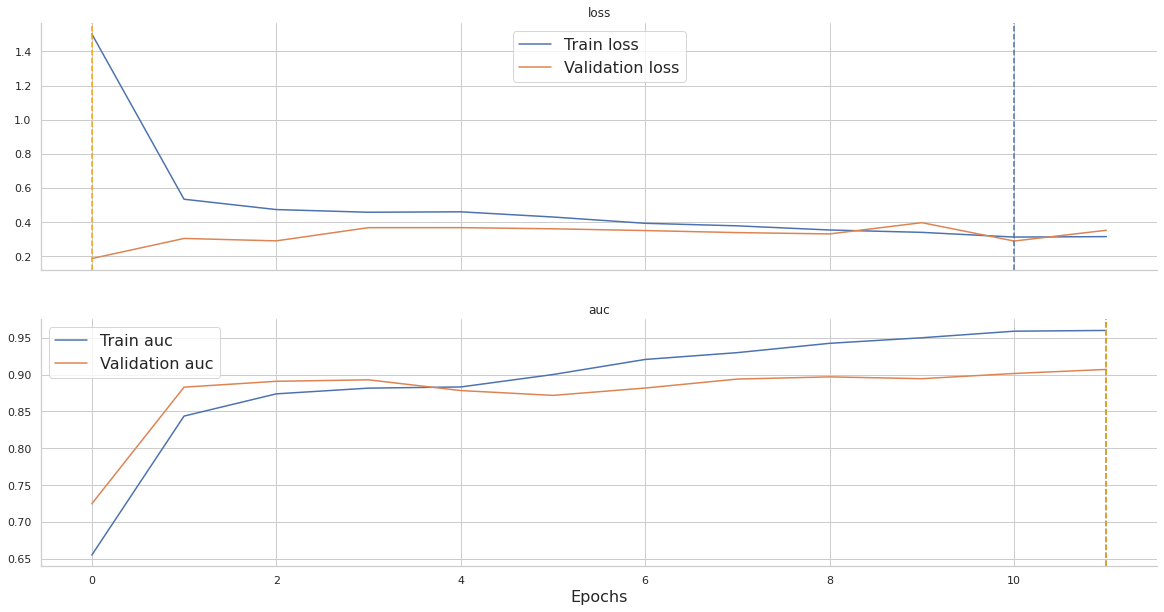

Fold: 3


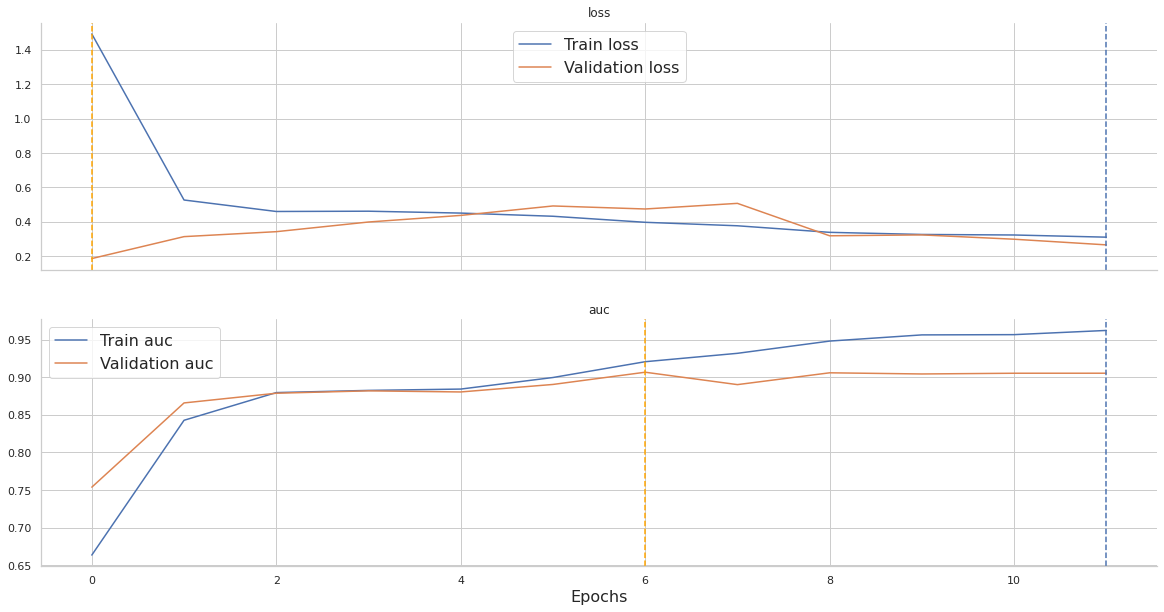

Fold: 4


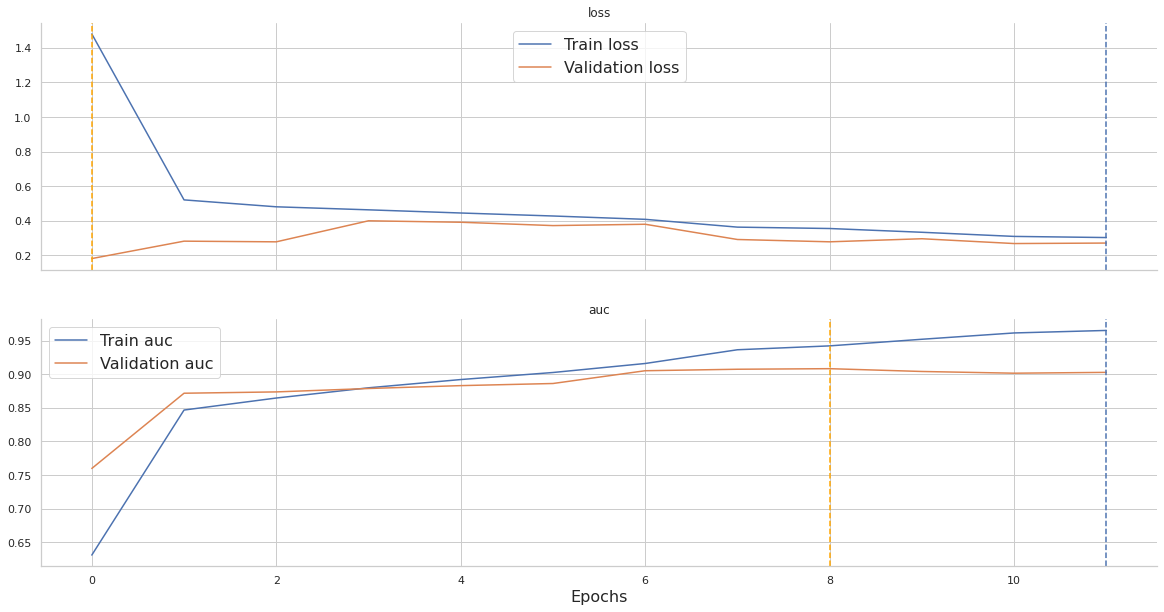

Fold: 5


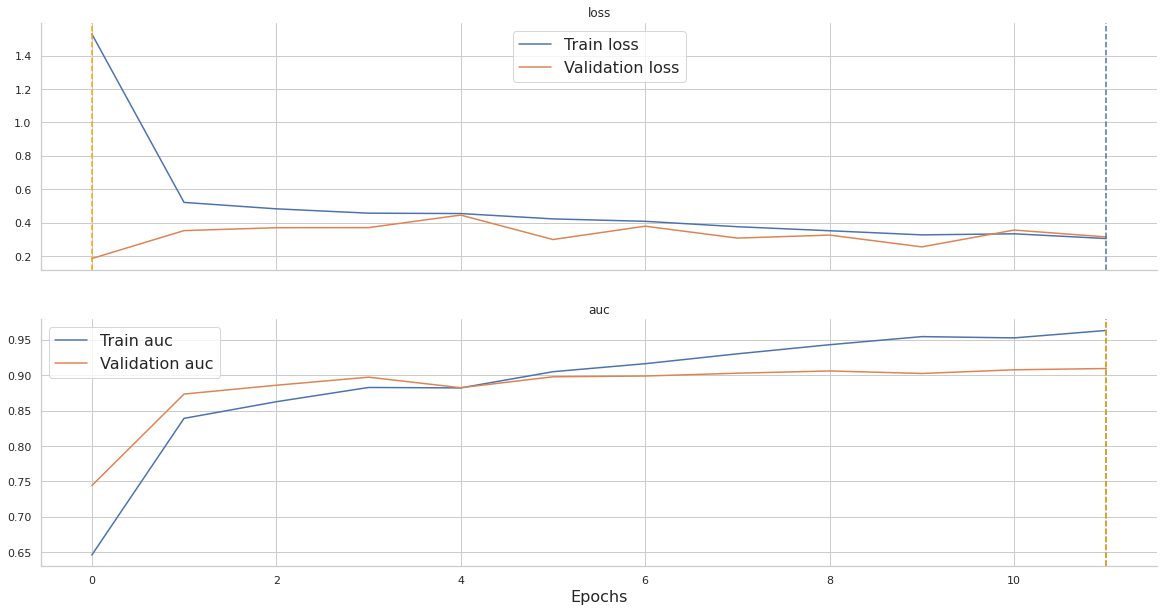

In [28]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

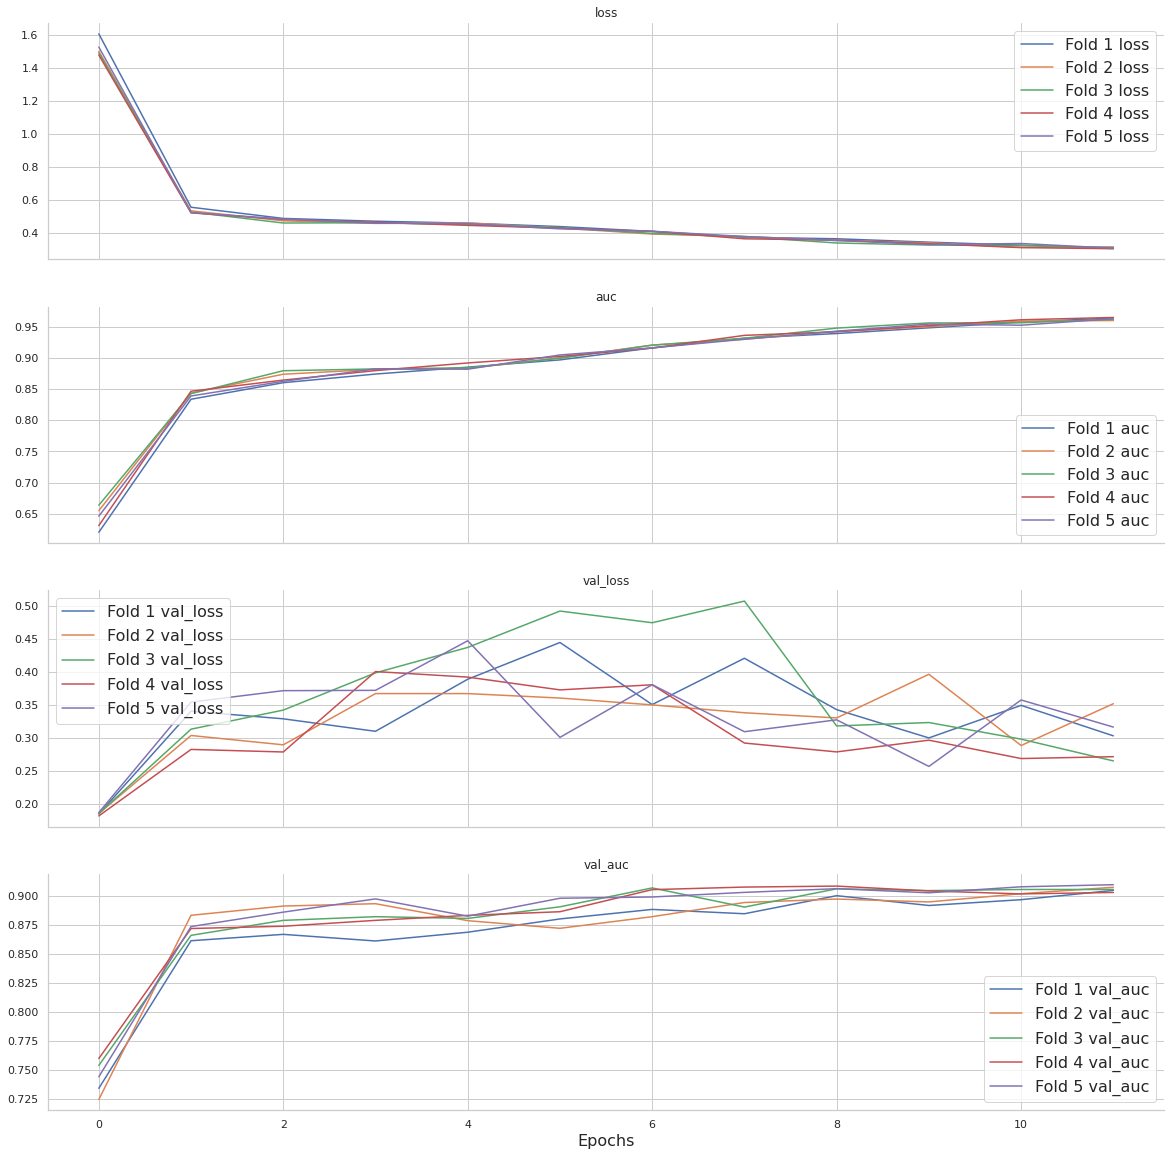

In [29]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [30]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.989340,0.905646,0.083693,0.989430,0.904726,0.988856,0.906296,0.989990,0.905207,0.990122,0.902505,0.988300,0.909497
Accuracy,0.915954,0.903153,0.012801,0.922591,0.903790,0.890536,0.874618,0.935422,0.922904,0.932548,0.920684,0.898674,0.893771
Precision,0.177335,0.119313,0.058022,0.185374,0.118605,0.138173,0.097473,0.211390,0.143969,0.204225,0.127451,0.147510,0.109065
Recall,0.987533,0.681591,0.305942,0.984199,0.723404,0.995781,0.736364,0.985138,0.654867,0.983051,0.580357,0.989496,0.712963
F1-score,0.299537,0.202038,0.097499,0.311986,0.203796,0.242674,0.172157,0.348087,0.236045,0.338192,0.209003,0.256746,0.189189
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [31]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.989340,0.905646,0.083693,0.989430,0.904726,0.988856,0.906296,0.989990,0.905207,0.990122,0.902505,0.988300,0.909497
male,0.988498,0.909000,0.079497,0.989822,0.921778,0.988821,0.902017,0.988711,0.914058,0.988186,0.901838,0.986949,0.905310
female,0.990039,0.896517,0.093522,0.988425,0.878474,0.988665,0.908660,0.991335,0.880915,0.992298,0.901403,0.989470,0.913132
head/neck,0.981027,0.876254,0.104772,0.982290,0.940233,0.978782,0.846588,0.982414,0.892570,0.976889,0.809096,0.984759,0.892785
upper extremity,0.989939,0.912275,0.077664,0.989667,0.899069,0.989547,0.895929,0.991087,0.924145,0.990931,0.925268,0.988463,0.916963
lower extremity,0.990835,0.869786,0.121049,0.992163,0.857617,0.990756,0.871195,0.989672,0.892924,0.993591,0.911838,0.987996,0.815357
torso,0.989120,0.922151,0.066970,0.988996,0.926004,0.988462,0.946570,0.990183,0.904889,0.989593,0.899968,0.988366,0.933322
0 <= age < 26,0.989416,0.858652,0.130764,0.989918,0.866783,0.988734,0.849768,0.989183,0.866906,0.990815,0.844105,0.988433,0.865699
26 <= age < 40,0.992047,0.906744,0.085304,0.991604,0.941565,0.992979,0.862341,0.992145,0.911151,0.991565,0.887156,0.991943,0.931505


# Model evaluation (best)

In [32]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.982143,0.907337,0.074805,0.989504,0.904687,0.988864,0.906529,0.967409,0.907338,0.976695,0.908510,0.988241,0.909623
Accuracy,0.887190,0.876287,0.010903,0.922712,0.904032,0.889905,0.873008,0.805038,0.799775,0.920105,0.911011,0.898190,0.893610
Precision,0.144728,0.104367,0.040361,0.185878,0.117096,0.137489,0.095352,0.081200,0.073208,0.171942,0.128378,0.147132,0.107801
Recall,0.977810,0.735435,0.242375,0.986456,0.709220,0.995781,0.727273,0.983015,0.858407,0.932203,0.678571,0.991597,0.703704
F1-score,0.250203,0.181477,0.068726,0.312813,0.201005,0.241618,0.168599,0.150008,0.134910,0.290333,0.215909,0.256243,0.186962
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.982143,0.907337,0.074805,0.989504,0.904687,0.988864,0.906529,0.967409,0.907338,0.976695,0.908510,0.988241,0.909623
male,0.981561,0.909866,0.071696,0.989901,0.921530,0.989011,0.902415,0.967668,0.916799,0.974410,0.902536,0.986816,0.906048
female,0.982244,0.899237,0.083007,0.988491,0.878678,0.988474,0.908693,0.966215,0.882491,0.978584,0.913496,0.989457,0.912828
head/neck,0.971132,0.881238,0.089894,0.983318,0.939535,0.979138,0.846371,0.947477,0.884830,0.960570,0.839367,0.985159,0.896087
upper extremity,0.982153,0.911707,0.070445,0.989651,0.898987,0.989383,0.897699,0.966691,0.914835,0.976804,0.930329,0.988234,0.916685
lower extremity,0.982485,0.868339,0.114146,0.992155,0.858171,0.990688,0.870925,0.965149,0.893391,0.976431,0.907180,0.988001,0.812030
torso,0.983141,0.924791,0.058350,0.989011,0.925752,0.988550,0.946472,0.970798,0.910917,0.979072,0.906750,0.988272,0.934064
0 <= age < 26,0.977992,0.857294,0.120698,0.989258,0.863287,0.988470,0.848608,0.945285,0.883094,0.978305,0.828384,0.988640,0.863095
26 <= age < 40,0.984786,0.915834,0.068952,0.991708,0.944190,0.993161,0.862928,0.968840,0.902818,0.978348,0.939746,0.991872,0.929487


# Confusion matrix

Fold: 1


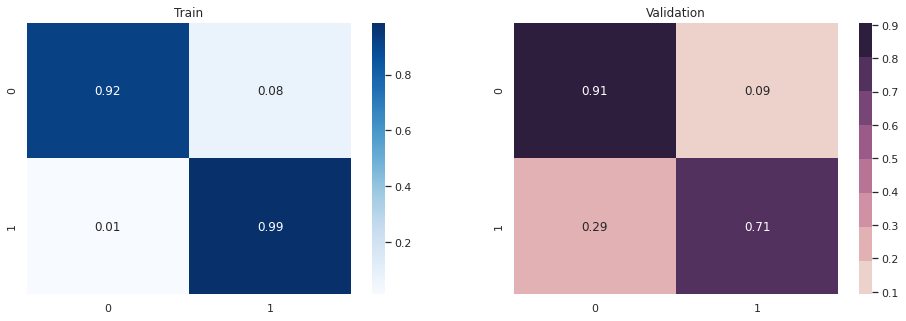

Fold: 2


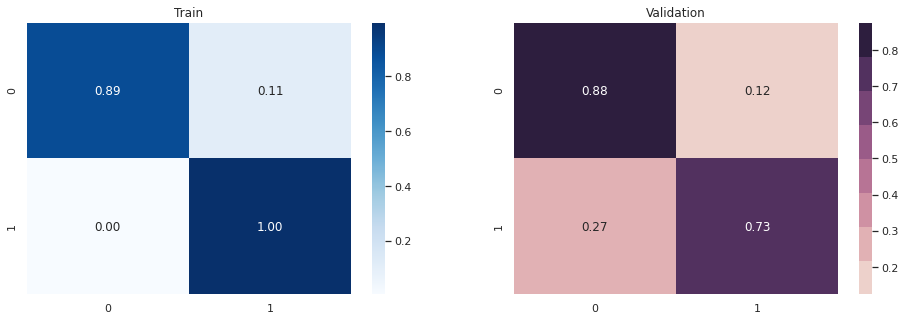

Fold: 3


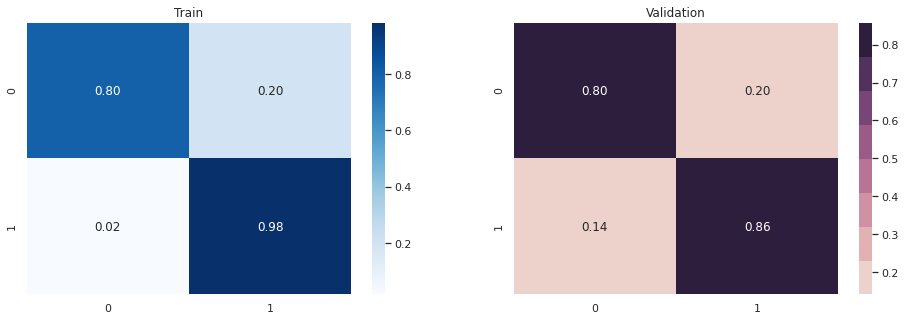

Fold: 4


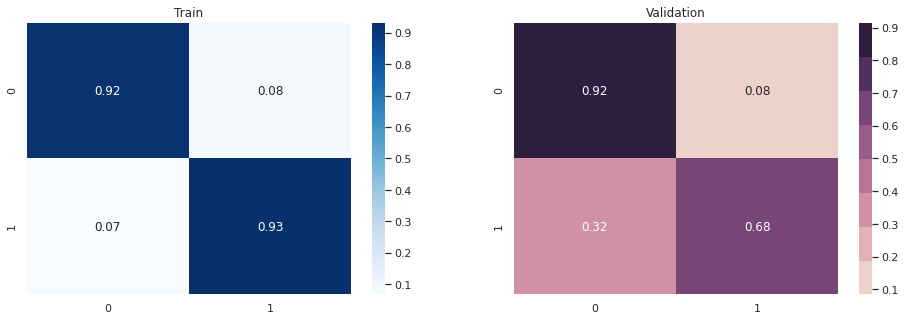

Fold: 5


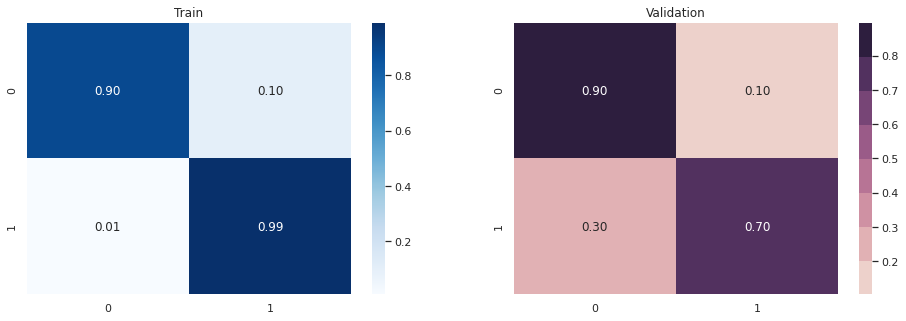

In [33]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [34]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 2964
Train positive correct predictions: 583
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.100380,0.011201,0.120347,0.122505,0.049265,0.198580
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.005581,0.005988,0.005092,0.005752,0.006801,0.004273
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.012063,0.010544,0.005866,0.017171,0.012968,0.013767
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.206742,0.042211,0.008968,0.477986,0.178854,0.325689
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.004207,0.004823,0.004322,0.005869,0.004136,0.001883
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.012570,0.009131,0.016614,0.009994,0.018521,0.008589
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.024271,0.032012,0.010778,0.025748,0.033678,0.019137
7,ISIC_0075663,female,35.0,torso,unknown,0,0.016161,0.010469,0.007818,0.035725,0.008660,0.018136
8,ISIC_0075914,male,30.0,torso,unknown,0,0.011063,0.005956,0.016557,0.013727,0.013578,0.005498
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.028100,0.025545,0.040611,0.014313,0.038236,0.021796


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.724372,0.008424,0.995216,0.964339,0.674174,0.979707
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.892839,0.733311,0.989371,0.858178,0.896265,0.987071
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.915998,0.966438,0.969562,0.671674,0.979297,0.993021
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.537259,0.101966,0.519440,0.353256,0.748470,0.963163
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.730576,0.103959,0.978989,0.986279,0.589490,0.994164
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.910403,0.986278,0.980405,0.816577,0.788394,0.980363
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.939338,0.998208,0.908529,0.973271,0.980284,0.836398
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.857870,0.704604,0.959045,0.832490,0.834260,0.958952
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.862892,0.676662,0.943186,0.803367,0.948780,0.942467
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.953013,0.991052,0.996116,0.861206,0.940694,0.975995


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.753808,0.826884,0.665183,0.542103,0.897388,0.837480
48,ISIC_0092870,male,55.0,torso,unknown,0,0.525810,0.209124,0.762620,0.533127,0.392263,0.731917
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.724372,0.008424,0.995216,0.964339,0.674174,0.979707
95,ISIC_0150975,female,50.0,lower extremity,unknown,0,0.507693,0.292525,0.736274,0.334350,0.474447,0.700870
111,ISIC_0155012,male,55.0,torso,nevus,0,0.617749,0.308062,0.624821,0.968984,0.426540,0.760339
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.556853,0.475826,0.580553,0.472993,0.574726,0.680166
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.703507,0.559959,0.862482,0.537696,0.685784,0.871617
156,ISIC_0166935,male,45.0,torso,unknown,0,0.574695,0.225827,0.684726,0.624535,0.908872,0.429512
166,ISIC_0170059,female,60.0,lower extremity,unknown,0,0.866387,0.973164,0.911694,0.618174,0.954431,0.874469
168,ISIC_0170285,female,45.0,upper extremity,unknown,0,0.798683,0.902761,0.863115,0.815250,0.782149,0.630138


# Visualize test predictions

In [35]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1465|9517
Test predictions (last) 1144|9838
Test predictions (tta) 1544|9438
Test predictions (last tta) 1204|9778
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.030744,0.018081,0.045736,0.021833
1,ISIC_0052349,male,40.0,lower extremity,0.007534,0.006227,0.010673,0.007516
2,ISIC_0058510,female,55.0,torso,0.003469,0.004109,0.009543,0.009752
3,ISIC_0073313,female,50.0,torso,0.004492,0.004964,0.005184,0.005828
4,ISIC_0073502,female,45.0,lower extremity,0.330184,0.227907,0.192052,0.139426
5,ISIC_0074618,male,50.0,lower extremity,0.192425,0.081803,0.131937,0.084505
6,ISIC_0076801,male,45.0,upper extremity,0.140446,0.056123,0.192257,0.135272
7,ISIC_0077586,male,50.0,lower extremity,0.248316,0.156945,0.247095,0.143535
8,ISIC_0082004,female,45.0,torso,0.255594,0.121953,0.202980,0.077495
9,ISIC_0082785,male,65.0,lower extremity,0.064081,0.023910,0.099098,0.038663


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
18,ISIC_0097719,male,45.0,torso,0.803989,0.673298,0.727216,0.556885
19,ISIC_0099348,female,45.0,upper extremity,0.592243,0.530193,0.595241,0.562174
22,ISIC_0105104,male,40.0,torso,0.651081,0.537032,0.496973,0.422923
24,ISIC_0112420,female,65.0,torso,0.850721,0.876092,0.889158,0.909297
42,ISIC_0155983,male,70.0,torso,0.941056,0.926309,0.942164,0.900591
56,ISIC_0169906,male,85.0,torso,0.791354,0.740958,0.775240,0.734788
57,ISIC_0171865,male,65.0,palms/soles,0.807552,0.802469,0.735966,0.764907
61,ISIC_0175798,female,55.0,torso,0.597668,0.484664,0.606996,0.523888
64,ISIC_0178235,female,70.0,lower extremity,0.752375,0.686938,0.623372,0.529212
69,ISIC_0182213,female,80.0,head/neck,0.750989,0.761883,0.730075,0.744920


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
18,ISIC_0097719,male,45.0,torso,0.803989,0.673298,0.727216,0.556885
19,ISIC_0099348,female,45.0,upper extremity,0.592243,0.530193,0.595241,0.562174
22,ISIC_0105104,male,40.0,torso,0.651081,0.537032,0.496973,0.422923
24,ISIC_0112420,female,65.0,torso,0.850721,0.876092,0.889158,0.909297
42,ISIC_0155983,male,70.0,torso,0.941056,0.926309,0.942164,0.900591
56,ISIC_0169906,male,85.0,torso,0.791354,0.740958,0.775240,0.734788
57,ISIC_0171865,male,65.0,palms/soles,0.807552,0.802469,0.735966,0.764907
64,ISIC_0178235,female,70.0,lower extremity,0.752375,0.686938,0.623372,0.529212
69,ISIC_0182213,female,80.0,head/neck,0.750989,0.761883,0.730075,0.744920
71,ISIC_0183449,female,60.0,lower extremity,0.814770,0.837758,0.759423,0.715829


# Test set predictions

In [36]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.030744,0.018081,0.024412,0.045736,0.021833,0.033785
1,ISIC_0052349,0.007534,0.006227,0.006881,0.010673,0.007516,0.009094
2,ISIC_0058510,0.003469,0.004109,0.003789,0.009543,0.009752,0.009648
3,ISIC_0073313,0.004492,0.004964,0.004728,0.005184,0.005828,0.005506
4,ISIC_0073502,0.330184,0.227907,0.279045,0.192052,0.139426,0.165739
5,ISIC_0074618,0.192425,0.081803,0.137114,0.131937,0.084505,0.108221
6,ISIC_0076801,0.140446,0.056123,0.098284,0.192257,0.135272,0.163764
7,ISIC_0077586,0.248316,0.156945,0.202631,0.247095,0.143535,0.195315
8,ISIC_0082004,0.255594,0.121953,0.188774,0.202980,0.077495,0.140237
9,ISIC_0082785,0.064081,0.023910,0.043995,0.099098,0.038663,0.068880


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.196848,0.161923,0.179385,0.205855,0.171979,0.188917
std,0.236513,0.222764,0.228681,0.237077,0.223662,0.229525
min,0.002681,0.002715,0.002841,0.002670,0.002806,0.002989
25%,0.019409,0.015180,0.017671,0.022697,0.017657,0.020464
50%,0.090642,0.053391,0.073353,0.100229,0.062966,0.083047
75%,0.294466,0.219397,0.257157,0.319031,0.247004,0.282303
max,0.990373,0.993541,0.990572,0.990197,0.991905,0.989516
